# SMOTE (numeric features only)
**OPIM 5512: Data Science Using Python - University of Connecticut**

-----------------------------------------------
Let's show how you can implement SMOTE by hand and by using the excellent `imblearn` library.

# Import modules and read data

In [ ]:
# this is to get rid of some annoying future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# the usual suspects...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for our nearest neighbor algorithm
from sklearn.neighbors import NearestNeighbors
# random number generator
import random
# counter
from collections import Counter


In [ ]:
# https://drive.google.com/file/d/1zhcJY3KXP6dcsaTla0X7EmTsVSx1jTrV/view?usp=sharing
!gdown 1zhcJY3KXP6dcsaTla0X7EmTsVSx1jTrV

Downloading...
From: https://drive.google.com/uc?id=1zhcJY3KXP6dcsaTla0X7EmTsVSx1jTrV
To: /content/housing_simple_DTR.csv
100% 12.4k/12.4k [00:00<00:00, 9.96MB/s]


In [ ]:
# mount your drive on the left
df = pd.read_csv('housing_simple_DTR.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   RM       489 non-null    float64
 1   LSTAT    489 non-null    float64
 2   PTRATIO  489 non-null    float64
 3   MEDV     489 non-null    float64
dtypes: float64(4)
memory usage: 15.4 KB


,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


Because we are using SMOTE and it's for regression, let's recode the target variable to be 0/1.

In [ ]:
# recoding in place - if greater than the median, it gets a 1, otherwise a 0
df['MEDV'] = np.where(df['MEDV']>np.mean(df['MEDV']), 1, 0)
df.head() # voila!

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,1
1,6.421,9.14,17.8,0
2,7.185,4.03,17.8,1
3,6.998,2.94,18.7,1
4,7.147,5.33,18.7,1


In [ ]:
from collections import Counter
Counter(df['MEDV'])

Counter({1: 224, 0: 265})

In [ ]:
# in this case, the 0s are the majority class
# and the 1s are the minority class
# our goal is to beef up the minority class with synthetic samples of the minority class

# Math and Theory

Here is an image of the pseduo-code. This snipped image comes from page 9 of the original research paper - which you can [view here](https://www.jair.org/index.php/jair/article/view/10302).

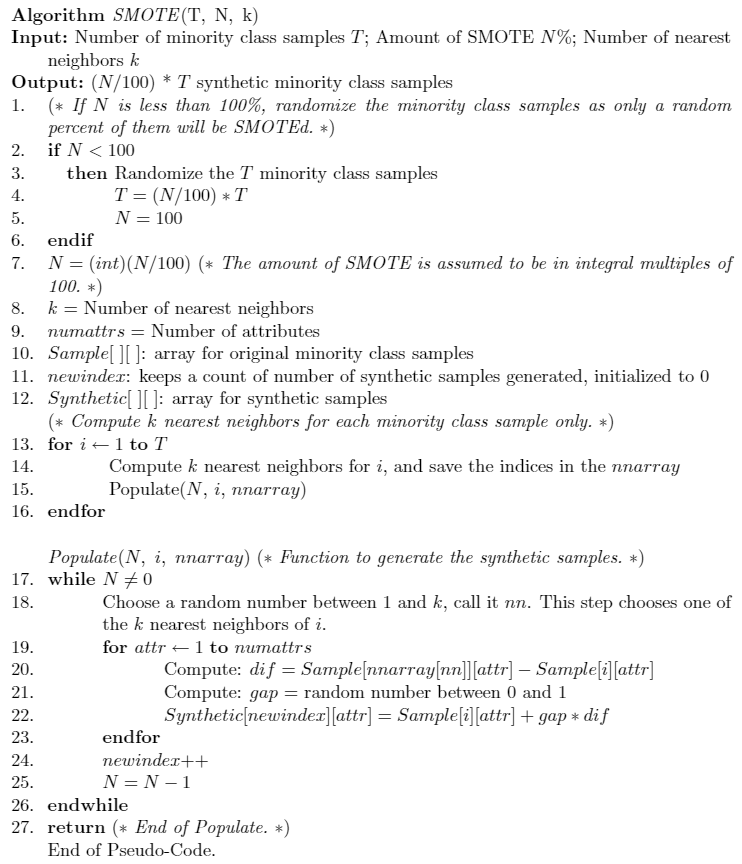

What do we see? You are going to
1. Pick a row of interest from the minority class. Call it `home`.
2. Find the 5 closest neighbors to the row of interest.
3. Randomly pick one of those five nearest neighbor rows. Call it `neighbor`.
4. For each numeric column, simply subtract the two rows `neighbor - interest`. Call this vector `dif`.
5. Pick a random number between 0 and 1. Call it `gap`.
6. Your new synthetic sample will be `home` + `gap` * `dif`. It is a (fake) row that lies randomly between `home` and `neighbor`!

That's it! Repeat this until you have a matching number of majority and minority class records.

Keep in mind that the original implementation of SMOTE only works for numeric features! This makes sense because you are subtracting rows - how could you subtract categories?!

In the future, you will learn about an extension to SMOTE called SMOTENC that allows you to account for numeric and categorical features - it simply picks the most common category among the neighbors - more on that later.

# An example of SMOTE (by hand)
Using the same terminology as above... I will work this out for you!

Split the data into X and y.

In [ ]:
X = df.drop('MEDV', axis=1)
X # these are our NUMERIC features

,RM,LSTAT,PTRATIO
0,6.575,4.98,15.3
1,6.421,9.14,17.8
2,7.185,4.03,17.8
3,6.998,2.94,18.7
4,7.147,5.33,18.7
...,...,...,...
484,6.593,9.67,21.0
485,6.120,9.08,21.0
486,6.976,5.64,21.0
487,6.794,6.48,21.0


In [ ]:
y = df['MEDV']
y

0      1
1      0
2      1
3      1
4      1
      ..
484    1
485    0
486    1
487    1
488    0
Name: MEDV, Length: 489, dtype: int64

## Step 1: pick a row of interest, call it `home`

In [ ]:
# pick a row of interest (we pick the first row for fun)
home = X.loc[0:0,]
home # here is our row

,RM,LSTAT,PTRATIO
0,6.575,4.98,15.3


### Brief refresher on k-Nearest Neighbors

k-nearest neighbors is one of the most common unsupervised learning methods. Extremely powerful for both classification and regression problems.

![knn in 2d space](https://miro.medium.com/max/800/1*2zYNhLc522h0zftD1zDh2g.png)

**Figure:** example of k-nearest neighbors in 2D space. Our hope is that the nearest datapoints are the most descriptive.

Original image source [here](https://miro.medium.com/max/800/1*2zYNhLc522h0zftD1zDh2g.png).


## Step 2: Find 5 closest neighbors
You can play with this as a hyperparameter, but 5 is what they used in the paper... so it's the default!

In [ ]:
# let's find the nearest neighbors
# the first row is itself (obvi it's the closest matching row)
nbrs = NearestNeighbors(n_neighbors=6).fit(X)
distances, indices = nbrs.kneighbors(X)
indices # we see that rows 0, 186, 188, 185, 183 and 269 are the closest neighbors
        # let's go find them!

array([[  0, 186, 188, 185, 183, 269],
       [  1,  90, 177,  44, 228, 303],
       [  2, 267, 220, 264, 333,  55],
       ...,
       [486, 487, 322, 338,  16, 339],
       [487, 486,  16, 323, 465, 101],
       [488,  13,  15, 101, 324, 349]])

So let's go take a peek at those rows!

In [ ]:
neighbors = X.loc[[186, 188, 185, 183, 269]]
neighbors

,RM,LSTAT,PTRATIO
186,6.739,4.69,15.2
188,6.800,5.03,15.6
185,6.951,5.10,15.2
183,6.556,4.56,15.2
269,6.812,4.85,14.9


And how does this look vs. our row of interest, `home`?

In [ ]:
home # look down at the nearest neighbor!

,RM,LSTAT,PTRATIO
0,6.575,4.98,15.3


They look SO SIMILAR! And this makes a lot of sense. And so now we will randnomly grab one row and call it `neighbor`. Don't get confused with the name `neighbors` (the five random rows) and `neighbor` (one sample row from the five rows).

## Step 3: Randomly pick one of the 5 neighbors

In [ ]:
neighbor = neighbors.sample(1)
neighbor # look up at the home row!

,RM,LSTAT,PTRATIO
269,6.812,4.85,14.9


## Step 4: Subtract `home - neighbor`, call it `dist`.

Now we just subtract the two rows and call it `dist`. Then we will find a random number called `gap` between 0 and 1, and multiply it by `dist`. Then we add it to the `home` row and VOILA a new synthetic datapoint.

In [ ]:
# in order to substract these rows, we need to reset the indices
home.reset_index(drop=True, inplace=True)
neighbor.reset_index(drop=True, inplace=True)

dist = home.subtract(neighbor)
dist # look up! can you see the difference?

,RM,LSTAT,PTRATIO
0,-0.237,0.13,0.4


## Step 5: Pick a random number between 0 and 1

Here's our random number.

In [ ]:
gap = random.uniform(0, 1)
gap

0.60600616309252

## Step 6: Make a synthetic row!
In practice, you could get rid of all of the random states and seeds then re-run.

Now, put it all together.

In [ ]:
newRow = home + gap*dist
newRow # ta da! This row does not exist, but it looks like the minority class!

,RM,LSTAT,PTRATIO
0,6.431377,5.058781,15.542402


Tada! You would repeat this until you get a matching number of rows. I hope you appreciate WHY you need numeric features only - you can do distance calculations on categorical variables (you would need to use dummy variables or another variant of the SMOTE algorithm).

Since we did not set any random states or seeds, your rows will be a little bit different - this is a good thing! The randomness is what we need to create synthetic data points.

# Using `imblearn` for SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y) # only for numeric!
Counter(y_res)

Counter({1: 265, 0: 265})

Yeah... it's that easy! But there's a lot of power behind that one line of code, and now you know what it does.

# SMOTE: before and after images
Here are some nice images from a dummy dataset. Imagine you only had two categories 0 (blue) and 1 (orange) and you had two features to describe them: X1 and X2. You can first see what the data looks like before SMOTE (note the counter values) and then after SMOTE.

You will see how SMOTE helps fill in the gaps.

Counter({0: 9900, 1: 100})


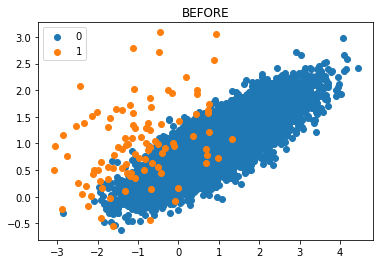

In [ ]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where

# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# look at class imbalance
counter = Counter(y)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.title('BEFORE')
plt.show()

Counter({0: 9900, 1: 9900})


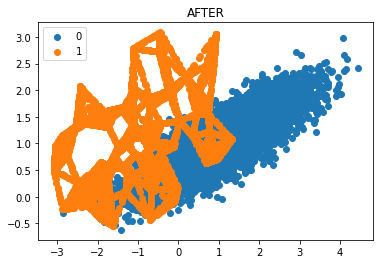

In [ ]:
# transform the dataset
oversample = SMOTE() # vanilla smote!
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.title('AFTER')
plt.show()

COOL!!!! I got that code off of Jason Brownlee's [excellent website](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/). You can see other variants like using an SVM instead of a k-nearest neighbor in order to generate your nearest neighbors.

# Hyperparameters
See the documentation for a full list of parameters that you can toggle.

There are MANY other variants that you can try... each with a different flavor - not good or bad, but each have important differences. Read the documentation of each for more details before using.

# Resources
* https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
* https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/